# Лабораторная работа 1

Задание:

Найти 3D модель и привести ее к различным формам представдения (меш, воксели, облако точек и функциональная).


## Импорт и установка необходимых библиотек

In [ ]:
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

In [ ]:
!pip install mesh_to_sdf pyrender trimesh

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install --upgrade setuptools wheel

In [ ]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes

# render
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader,
    PointLights
)

from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface

# trimesh lib imports
import trimesh
from trimesh.voxel.creation import voxelize

In [ ]:
from pytorch3d.renderer.mesh import Textures

## Импорт модели

In [ ]:
# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

In [ ]:
path_to_model = os.path.join("Jess_Casual_Walking.obj")

## Полигональная модель

In [ ]:
# Trimesh .obj model
jess_trimesh = trimesh.load(path_to_model)

if isinstance(jess_trimesh, trimesh.Scene):
    bunny_trimesh = jess_trimesh.dump(concatenate=True)

jess_trimesh.vertices -= jess_trimesh.center_mass
scaling = 2 / jess_trimesh.scale
jess_trimesh.apply_scale(scaling=scaling)

# Jess mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a meshes object for the Jess.
jess_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [ ]:
# OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024,
    blur_radius=0,
    faces_per_pixel=1,
)

# We can add a point light in front of the object.
#lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)

lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
        )
)

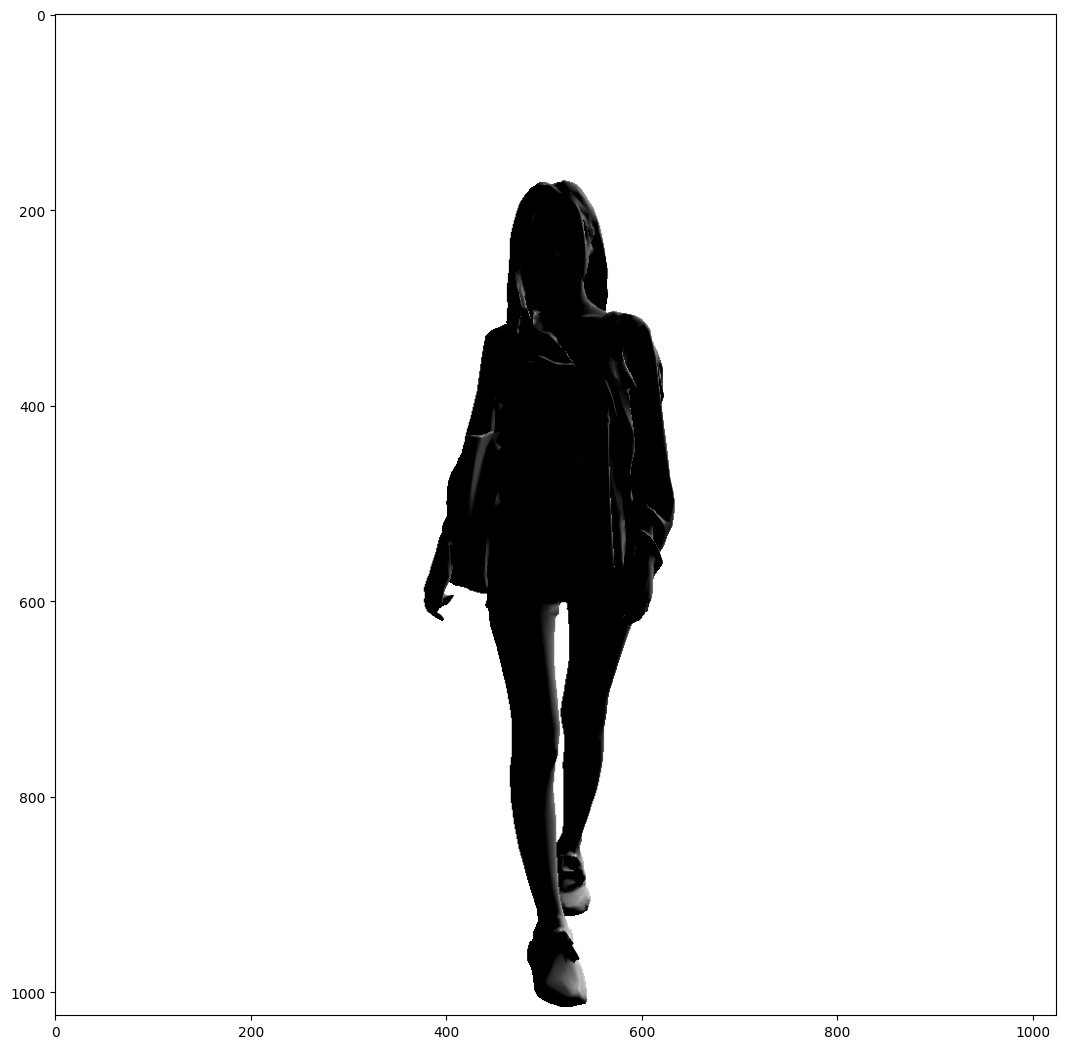

In [ ]:
# Select the viewpoint using spherical angles
distance = 2.0   # distance from camera to the object`
elevation = -89.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the Jess providing the values of R and T.
image_jess = phong_renderer(meshes_world=jess_mesh, R=R, T=T)

image_jess = image_jess.cpu().numpy()

plt.figure(figsize=(13, 13))
plt.imshow(image_jess.squeeze())
plt.grid(False)

In [ ]:
jess_trimesh.show()

## Воксельная модель

In [ ]:
low_idx_jess = jess_trimesh.scale / 15
high_idx_jess = jess_trimesh.scale / 100

vox_high_jess = voxelize(jess_trimesh,pitch=high_idx_jess)
vox_low_jess = voxelize(jess_trimesh,pitch=low_idx_jess)

print("Размер воксельной сетки с высоким разрешением:", vox_high_jess.shape)
print("Размер воксельной сетки с низким разрешением:", vox_low_jess.shape)
print("Срез воксельной сетки:\n",np.array(vox_high_jess.matrix, dtype=np.uint8)[1])


Размер воксельной сетки с высоким разрешением: (30, 34, 91)
Размер воксельной сетки с низким разрешением: (5, 6, 15)
Срез воксельной сетки:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
vox_high_jess.show()

In [ ]:
vox_low_jess.show()

## Облако точек

In [ ]:
# Mesh to pointcloud with normals in pytorch3d
num_points_to_sample = 25000

jess_vert, jess_norm = sample_points_from_meshes(
    jess_mesh,
    num_points_to_sample ,
    return_normals=True
)

In [ ]:
def plot_pointcloud(points, elev=70, azim=-70, title=""):
    # Sample points uniformly from the surface of the mesh.
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    x, y, z = points
    ax.scatter3D(x, z, -y, marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev, azim)
    plt.show()

In [ ]:
points = sample_points_from_meshes(jess_mesh, 5000)
points = points.clone().detach().cpu().squeeze().unbind(1)
plot_pointcloud(points, elev=190, azim=150, title='Jess pytotch3d mesh obj')

<Figure size 1000x1000 with 0 Axes>

## Функциональная модель

Вычисление SDF функции для внутренних и внешних точек модели:

In [ ]:
center_mass = jess_trimesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])

for point in query_points:
    print("SDF{0} = {1}".format(point[0],mesh_to_sdf(jess_trimesh,point)[0]))

SDF[-4.22625216e-18 -1.79615717e-18  1.08192055e-16] = -0.047370728105306625
SDF[3. 3. 3.] = 4.783071994781494


Визуализация SDF, точки разукрашены в градиент значения функции:

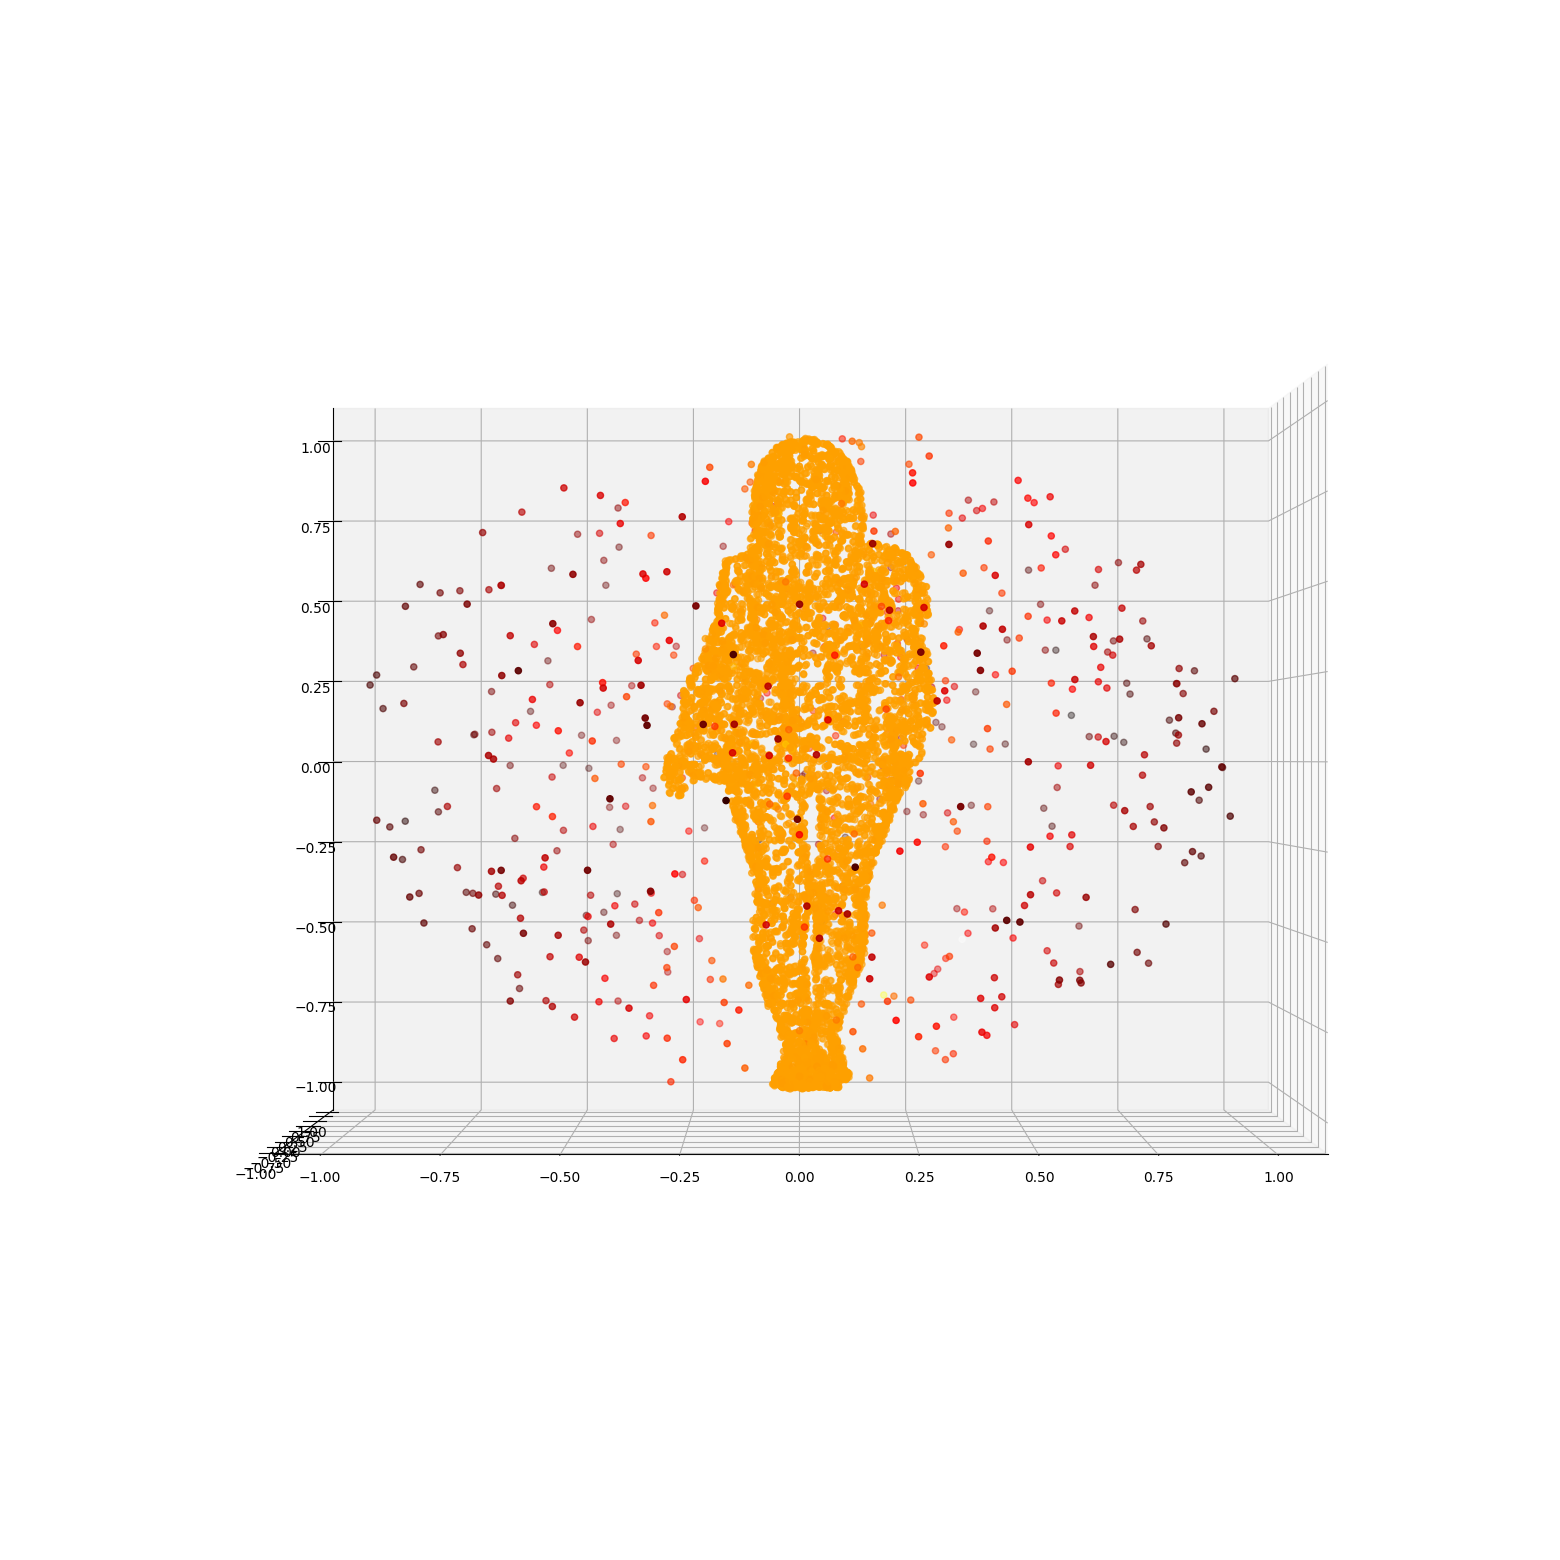

In [ ]:
points, sdf = sample_sdf_near_surface(jess_trimesh, number_of_points=10000)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection="3d")
ax.view_init(elev=0, azim=-90)
ax.scatter(points[:, 0], points[:, 1], zs=points[:, 2], c=sdf, cmap="hot_r")